In [44]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import datetime as dt
from ipywidgets import *
from IPython.display import display
desired_width = 360
pd.set_option('display.width', desired_width)
from IPython.display import display, HTML
import datetime

display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
</style>
"""))
 

In [49]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [3]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts=[], refPts=[], xlim=[], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize'] = [16,4]
    # plt.subplot(6,1,1)
    fig, ax1 = plt.subplots()
    ax1.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    
    for pt in theftpts:
        ax1.axvline(pt, color = 'black')
        
    for pt in refPts:
        ax1.axvline(pt, color = 'Red')
    plt.show()


In [4]:
def plot_Results(df, df_clean, result_df, theftpts=[], refPts=[], xlim = [], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize']=[16,12]
    fig, axi = plt.subplots(4, 1)
    axi[0].plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    axi[0].set_title('Original FuelData vs Time')
    axi[0].set_xlabel('time')

    axi[1].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[1].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[1].set_ylabel('FuelVoltage', color='b')
    axi[1].tick_params('y', colors='b')
    if len(ylim1) != 0:
        axi[1].set_ylim(ylim1)

    ax2 = axi[1].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2) != 0:
        ax2.set_ylim(ylim2)
    if len(xlim) != 0:
        plt.xlim(xlim)
    axi[1].set_title('Cleaned Data')
        
    for pt in refPts:
        axi[1].axvline(pt, color = 'Red')
    
    
    
    axi[2].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[2].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[2].set_ylabel('FuelVoltage', color='b')
    axi[2].tick_params('y', colors='b')
    if len(ylim1)!=0:
        axi[2].set_ylim(ylim1)

    ax2 = axi[2].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        axi[2].set_ylim(ylim2)
        
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Final Predicted Theft Pts - ZOOMED')

    for pt in result_df.theft_index:
        plt.axvline(pt, color = 'black')
        

    axi[3].plot(result_df.theft_index, result_df['fuel_VoltageJump'], 'g-', markersize=3, linewidth=1);
    axi[3].set_title('Fuel/km Ratio at Predicted theft pts - ZOOMED')
    
    axi[3].set_xlabel('time index')
    
    fig.tight_layout()

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

In [5]:
def findMax_decayRate(cleanDf):

    i = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    avgDT = []
    indexlst = []
    dist = cleanDf.distance[i] - cleanDf.distance[0]
    while (i<len(cleanDf)) and (dist <= 5000): 
        df = 0
        dist = 0.001*(cleanDf.distance[i] - cleanDf.distance[0])
        print(dist)
        dfRef = cleanDf.fuelVoltage[i]
        dsRef = cleanDf.distance[i]
        while (df<=dt  and i<len(cleanDf)):
            df = dfRef - cleanDf.fuelVoltage[i] 
            if df <0 :
                dfRef = cleanDf.fuelVoltage[i]
            i+=1
            #print(i)

        if i<len(cleanDf):
            ds = cleanDf.distance[i] - dsRef
            if df>0 :
                #print (i)
                if ds==0:
                    ds = df/1000
                    #print("df = ",df,"****",i)
                avg = df/ds
                avgDT.append(avg)
                indexlst.append(cleanDf.index[i])

    med = pd.Series(avgDT).median()
    mean = pd.Series(avgDT).mean()
    avg = pd.Series(avgDT)
    max_dCRate = avg.median()+ 3*(abs(avg - avg.median()).median())
        
    return pd.Series(avgDT), indexlst, 1000*max_dCRate


In [6]:
i=j=0
while (i<10) and j<3 :
    print (i,j)
    i+=1
    j+=1

0 0
1 1
2 2


In [7]:
#####################################################################
### Function to generate FuelMaxVoltage & FuelMinVoltage, to be sent
### to the main devices database for records.
def Gen_FuelMaxMin(df):
    df = dr.perform_PreFormating(df)
    dff, dff2 = dr.perform_postFormating(df)

    y_smooth = sp.signal.medfilt(dff.fuelVoltage, 99)
    fmax = max(y_smooth)
    fmin = min(y_smooth)
    #df_clean = dc.Clean_NoiseData(dff, fmax, fmin, 0)

    return fmax, fmin


In [73]:
folderpath = r"H:\Analytics\FuelAnalysis\test3\spcase"
savePath = r"H:\Analytics\FuelAnalysis\results"
filepath = r""
df_list = []
filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=8)
for file in filesname:
    df = dr.read_SingleCSV(file)
    df_list.append(df)

ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) + "Preformatting Done")

    dff, dff2 = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff,dff2

def cleanDF(dff, fuelMax, fuelMin, neb_ds):
    df_clean = dc.Clean_NoiseData(dff, fuelMax, fuelMin, neb_ds)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean, fuelMax, fuelMin, neb_dst):
    theft_pts, refpts = dc.jump_point(df_clean, 0.01, fuelMax, fuelMin, neb_dst)
    print("Dataset_" + str(ctr + 1) + " Theft & Refuel points Indentified")
    return theft_pts, refpts

    

H:\Analytics\FuelAnalysis\test3\spcase\cordinates_008527943201.csv


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (0,1,2,4,5,6,7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


H:\Analytics\FuelAnalysis\test3\spcase\cordinates_008527947553.csv
H:\Analytics\FuelAnalysis\test3\spcase\cordinates_009821704415.csv
H:\Analytics\FuelAnalysis\test3\spcase\cordinates_009821749528.csv
H:\Analytics\FuelAnalysis\test3\spcase\cordinates__008527814724.csv
H:\Analytics\FuelAnalysis\test3\spcase\cordinates__008527817582.csv
H:\Analytics\FuelAnalysis\test3\spcase\cordinates__008527944841.csv
H:\Analytics\FuelAnalysis\test3\spcase\cordinates__009821939801.csv


In [110]:
#plotData_profiles(df)
df = df_list[0]
df = df[:]
df = df.reset_index(drop= True)
df.st = df.io_state.apply(lambda x: str(x)[1])
dis = df[df.st == '0'].distance.apply(lambda x: int(x))

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


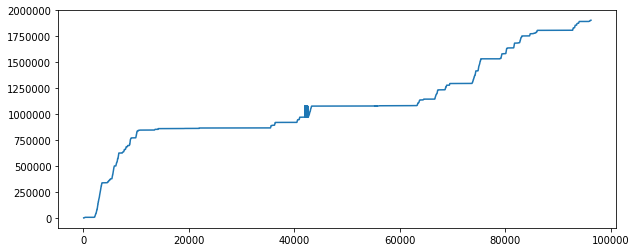

In [111]:
plt.rcParams['figure.figsize'] = [10,4]
plt.plot(dis);

In [112]:
fuelMax, fuelMin = Gen_FuelMaxMin(df)

96261
5475
LenPostFormating:  5475


In [113]:
fuelMax, fuelMin

(1327.0, 280.0)

In [114]:
dff, dff2 = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1Preformatting Done
96261
5475
LenPostFormating:  5475
Dataset_1 Postformatting Done


In [115]:
df = dr.perform_PreFormating(df)

In [116]:
d = df[df.dev_state=='0']
len(d[d.fuelVoltage <= 5])

81471

In [117]:
len(df[df.dev_state=='0'])

83154

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96261 entries, 0 to 96260
Data columns (total 7 columns):
datetime       96261 non-null datetime64[ns]
lat            96261 non-null object
long           96261 non-null object
speed          96261 non-null float64
distance       96261 non-null float64
fuelVoltage    96261 non-null float64
dev_state      96261 non-null object
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 5.1+ MB


(736761.0833333334, 736796.2881944445)

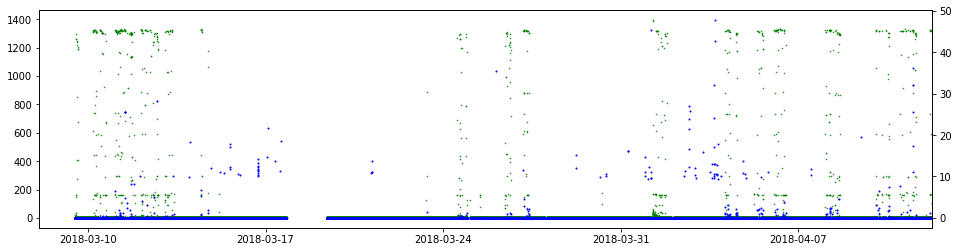

In [124]:

plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df[df.dev_state=='0'].datetime, df[df.dev_state=='0'].fuelVoltage, 'g.', markersize =1);
plt.twinx()
plt.plot(df[df.dev_state=='0'].datetime, df[df.dev_state=='0'].speed, 'b.', markersize = 2);
plt.xlim(datetime.datetime(2018,3,8,2,0), datetime.datetime(2018,4,12,6,55))
#plt.ylim(0,8)

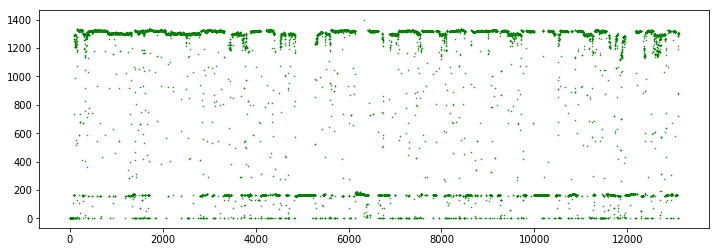

In [97]:
%matplotlib inline
df= df[df.dev_state=='1'].reset_index(drop = True)
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(df.index, df.fuelVoltage, 'g.', markersize = 1);

In [98]:
len(df[df.dev_state=='1']), len(df[df.dev_state=='0'])

(13107, 0)

In [99]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 7 columns):
datetime       5475 non-null datetime64[ns]
lat            5475 non-null object
long           5475 non-null object
speed          5475 non-null float64
distance       5475 non-null float64
fuelVoltage    5475 non-null float64
dev_state      5475 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 299.5+ KB


In [100]:
len(dff), len(dff2)

(5475, 13107)

In [101]:
a=[1,2,3,4,5,6]
a[0]

1

In [102]:
dff3 = dff2[dff2.fuelVoltage<=200]

In [103]:
dff.loc[0,'datetime'] - dff.loc[len(dff)-1,'datetime']

Timedelta('-25 days +19:12:02')

In [104]:
dff2.loc[0,'datetime'] - dff.loc[0,'datetime']

Timedelta('-71 days +06:11:28')

In [105]:
dff2.loc[0,'datetime'] - dff.datetime.min()

Timedelta('-71 days +06:11:28')

In [106]:
dff2.datetime[:10]

0   2018-01-11 14:38:09
1   2018-01-11 14:38:39
2   2018-01-11 14:39:09
3   2018-01-11 14:39:39
4   2018-01-11 14:40:09
5   2018-01-11 14:40:39
6   2018-01-11 14:41:09
7   2018-01-11 14:41:39
8   2018-01-11 14:42:09
9   2018-01-11 14:43:10
Name: datetime, dtype: datetime64[ns]

In [107]:

dff.datetime[0]

Timestamp('2018-03-23 08:26:41')

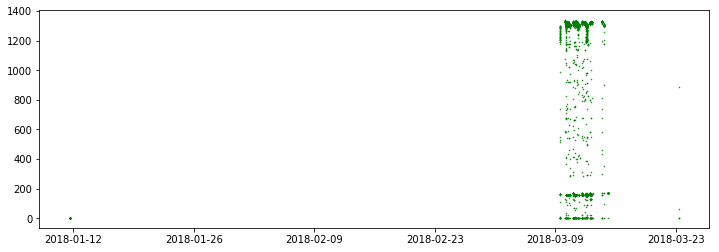

In [108]:
%matplotlib inline
dff2= dff2[dff2.dev_state==1].reset_index(drop=True)
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(dff2[dff2.datetime<=dff.datetime.min()].datetime, dff2[dff2.datetime<=dff.datetime.min()].fuelVoltage,'g.', markersize = 1);
#plt.xlim(0,20000)



3.0

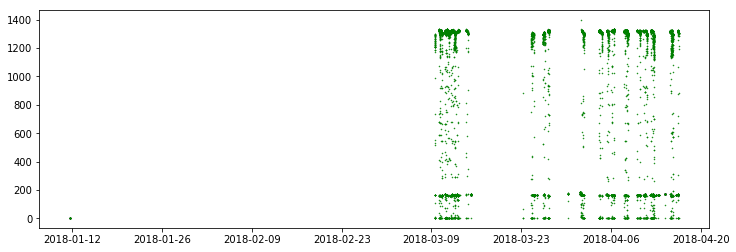

In [109]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(dff2.datetime, dff2.fuelVoltage,'g.', markersize = 1);
#plt.xlim(0,30000)
(dff3.fuelVoltage.min())


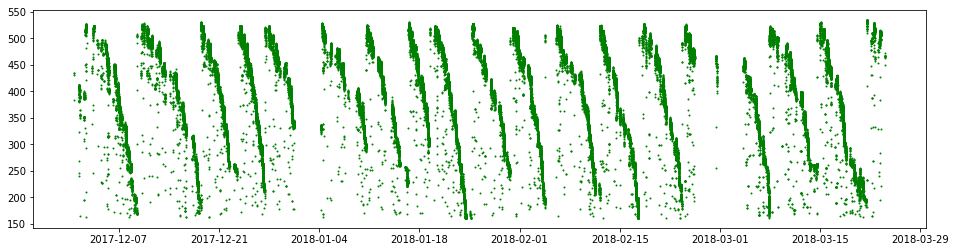

In [31]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.datetime, dff.fuelVoltage, 'g.', markersize = 2)
#plt.ylim(2,4)
#plt.xlim(32000,38000)

In [32]:
dff.fuelVoltage.median()

412.0

In [33]:
dff.fuelVoltage.std()

94.2134877291852

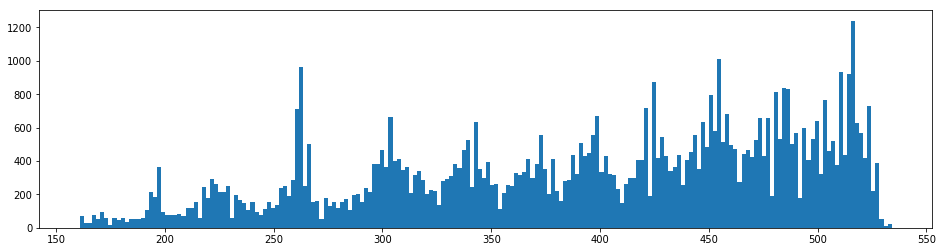

In [34]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]
plt.hist(dff.fuelVoltage,200);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

In [35]:
x = '0'
x.zfill(8)
import time

In [36]:
def Clean_NoiseData2(dff, fuelMax, fuelMin, nds):
    x = pd.Series(dff.index)
    y = pd.Series(dff.fuelVoltage)
        
    ## Neighbourhood Distance
    Nds = 0.01*(fuelMax - fuelMin)
    if nds:
        Nds = nds
    print(Nds)

    
    dff['dd00000'] = abs(y - y.shift(6))
    dff['dd0000'] = abs(y - y.shift(5))
    dff['dd000'] = abs(y - y.shift(4))
    dff['dd00'] = abs(y - y.shift(3))
    dff['dd0'] = abs(y - y.shift(2))
    dff['dd1'] = abs(y - y.shift(1))
    dff['dd2'] = abs(y - y.shift(-1))
    dff['dd3'] = abs(y - y.shift(-2))
    dff['dd4'] = abs(y - y.shift(-3))
    dff['dd5'] = abs(y - y.shift(-4))
    dff['dd6'] = abs(y - y.shift(-5))
    dff['dd7'] = abs(y - y.shift(-6))
    dff['dd8'] = abs(y - y.shift(-7))
    
    dforward = pd.DataFrame()
    dbackward = pd.DataFrame()
    for i in range(1,10):
        dforward['d'+str(i)] = abs(y - y.shift(i))
        dbackward['d'+str(i)] = abs(y - y.shift(-1*i))
    dbackward = dbackward.fillna(0)
    dforward = dforward.fillna(0)
    
    dff2 = dff[(dforward.d1 <= Nds) & (dbackward.d1 <= Nds) & (dforward.d2 <= 2*Nds) & (dbackward.d2 <= 2*Nds) &
               (dforward.d3 <= 3*Nds) & (dbackward.d3 <= 3*Nds) & (dforward.d4 <= 4*Nds) & (dbackward.d4 <= 4*Nds) &
               (dforward.d5 <= 5*Nds) & (dbackward.d5 <= 5*Nds) & (dforward.d6 <= 6*Nds) & (dbackward.d6 <= 6*Nds) &
               (dforward.d7 <= 7*Nds) & (dbackward.d7 <= 7*Nds) & (dforward.d8 <= 8*Nds) & (dbackward.d8 <= 8*Nds)]
    dff2 = dff2.reset_index(drop = True)
    

    p = dff['dd1']
    ## Removing Error Data
    dff1 = dff[(dff.dd1 <= Nds) & (dff.dd2 <= Nds) & (dff.dd0 <= 2*Nds) & (dff.dd3 <= 2*Nds) &
               (dff.dd00 <= 3*Nds) & (dff.dd4 <= 3*Nds) & (dff.dd000 <= 4*Nds) & (dff.dd5 <= 4*Nds) &
               (dff.dd0000 <= 5*Nds) & (dff.dd6 <= 5*Nds) & (dff.dd00000 <= 6*Nds) & (dff.dd7 <= 6*Nds)]
    dff1 = dff1.reset_index(drop=True)  ## Reseting index
    #print (dff1[['dd1','dd0','dd00','dd000','dd0000','dd00000']].head(40))

    # plt.rcParams['figure.figsize'] = [16, 4]
    # plt.plot(p, 'b.')
    # plt.title('Histogram - Consecutive Fuel Difference ', fontsize=15)
    # plt.ylim(0, 0.05)
    #
    # #     plt.ylim(0.02,1)
    # #     plt.savefig("test.png")
    # plt.rcParams['figure.figsize'] = [16, 4]
    # plt.plot(dff.index[:], dff.fuelVoltage[:], 'g.', markersize=2, linewidth=1);
    # plt.ylim(0, 1.1)
    dfClean = dff1[['datetime','lat', 'long','speed','distance','fuelVoltage']]
    dfClean['fuelVoltage_Percent'] = dfClean.fuelVoltage.apply(lambda x: round((100*x/(fuelMax - fuelMin)),2))
    dfClean2 = dff2[['datetime','lat', 'long','speed','distance','fuelVoltage']]
    dfClean2['fuelVoltage_Percent'] = dfClean2.fuelVoltage.apply(lambda x: round((100*x/(fuelMax - fuelMin)),2))

    return dfClean, dfClean2

In [37]:
import time
strttime = time.time()
dfcln, dfcln2 = Clean_NoiseData2(dff.copy(), fuelMax, fuelMin,0)
print(time.time()-strttime)

3.64


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.8365881443023682


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
y = pd.Series([1,2,3,4,5,6,7,8])
y.shift(-1) -y

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    NaN
dtype: float64

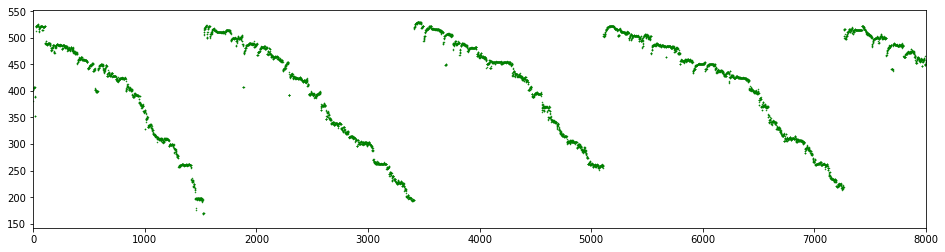

In [39]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dfcln2.index, dfcln2.fuelVoltage,  'g.', markersize = 1)
#plt.ylim(300,580)
plt.xlim(0,8000)
plt.savefig("cleanf22.png")

In [40]:
df_clean = dff

In [41]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
 
t = np.linspace(0,10,200) # create a time signal
x1 = np.sin(t) # create a simple sine wave
x2 = x1 + np.random.rand(200) # add noise to the signal

def f(x):
    y1 = sp.signal.medfilt(df_clean.fuelVoltage,x) # add noise to the signal
    # plot the results
    plt.subplot(2,1,1)
    plt.plot(df_clean.index,df_clean.fuelVoltage,'g.', markersize = 1)
    plt.title('input wave')
    plt.xlabel('time')
    plt.xlim(10000, 30000)
    plt.subplot(2,1,2)
    plt.plot(df_clean.index,y1,'g.', markersize = 1)
    plt.title('filtered wave')
    plt.xlabel('time')
    plt.xlim(10000, 30000)
    plt.show()
interact(f, x= IntSlider(min=1, max=200, step=2,value=99));

interactive(children=(IntSlider(value=99, description='x', max=200, min=1, step=2), Output()), _dom_classes=('…

In [42]:
y1 = sp.signal.medfilt(df_clean.fuelVoltage,99) 
len(df_clean), len(y1)

(66076, 66076)

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


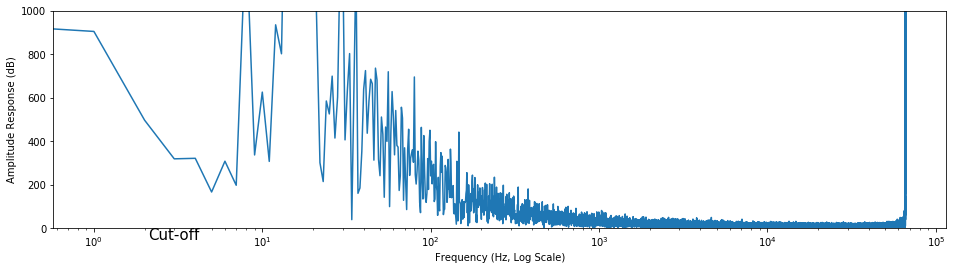

In [43]:
from scipy.fftpack import fft
from scipy import signal as sg
import statsmodels.api as sm
from scipy.signal import butter, lfilter, freqz
import datetime

normdata = df_clean.fuelVoltage/df_clean.fuelVoltage.max()
yvolt = fft(df_clean.fuelVoltage/df_clean.fuelVoltage.max())

plt.rcParams['figure.figsize'] = [16,4]
plt.ylim(0,1000);
plt.plot(np.abs(yvolt[:]));
plt.rcParams['figure.figsize'] = [16,4]
plt.xscale('log')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (Hz, Log Scale)')
#plt.axvline((2.5, color = 'black')
plt.text(2.1,-50, "Cut-off", fontsize = 15);

def butter_lowpass_filter(data, cutoff, fs, order=5, ftype = False):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=ftype)
    y = lfilter(b, a, data)
    y1 = sg.filtfilt(b,a, data)
    return y


# Filter the data, and plot both the original and filtered signals.
fs = 500             # Sampling Frequency
order = 5             # Order of Filter
cutoff = 10          # Filter Cut-off Frequency

df = df_clean.copy()
# Calling Butterworth filter
y2 = df_clean.fuelVoltage.max() *(butter_lowpass_filter(normdata, cutoff, fs, order, ftype= False))
time = df.datetime

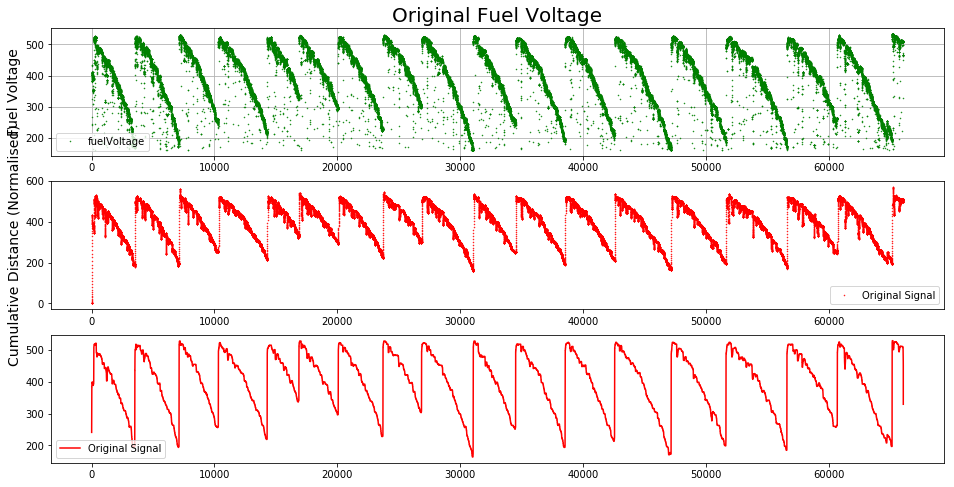

In [44]:
#Plotting Results
plt.rcParams['figure.figsize'] = [16,8]

plt.subplot(3, 1,1)
#plt.plot(time, norm_data, 'b-', linewidth=1, label='Original Signal')
plt.plot(df.index, df.fuelVoltage, 'g.', markersize = 1, linewidth = 1)
plt.legend()
plt.grid()
plt.ylabel('Fuel Voltage',  fontsize = 14)
#plt.xlim(0,12000)
plt.title('Original Fuel Voltage', fontsize = 20)
#plt.ylim(df_clean.fuelVoltage.min(), 1.05*df_clean.fuelVoltage.max())
#plt.axvline(60000, color = 'black')

plt.subplot(3, 1,2)
plt.plot(df.index, y2, 'r.', markersize=1, label='Original Signal')
plt.legend()
#plt.xlim(0,12000)
#plt.ylim(df_clean.fuelVoltage.min(), 1.05*df_clean.fuelVoltage.max())
plt.ylabel('Cumulative Distance (Normalised)',  fontsize = 14)
#plt.xlim(datetime.datetime(2018,1,27,2,0), datetime.datetime(2018,2,15,6,55))
plt.subplot(3, 1,3)
plt.plot(df_clean.index, y1, 'r-', markersize=1, label='Original Signal')
plt.legend()
#plt.xlim(0,12000)

#plt.tight_layout()

In [45]:
#df_clean = cleanDF(dff.copy(), fuelMax, fuelMin,0)

In [46]:
df_clean2 = dff.copy()
df_clean2.fuelVoltage = pd.Series(y1)

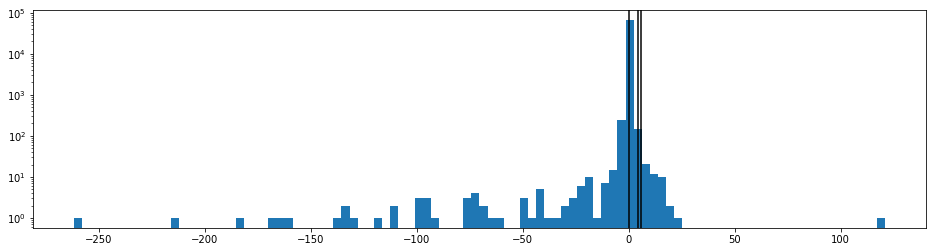

In [47]:
def avg_NeigbourDistance(dff):
    dd = dff.fuelVoltage - dff.fuelVoltage.shift(-1)  
    dd = dd.dropna()
    #print(dd
    plt.rcParams['figure.figsize'] = [16,4]

    plt.hist(dd, bins=100)
    plt.axvline(dd.median(), color = 'black')
    plt.axvline(2*dd.std(), color = 'black')
    plt.axvline(1.5*dd.std(), color = 'black')
    plt.semilogy()
    return dd
dd = avg_NeigbourDistance(df_clean2)

In [48]:
dd2 = dd[abs(dd - dd.median()) < 2*dd.std()]
meddev = abs(dd2 - dd2.median()).median()
meddev2 = abs(dd2 - dd2.median()).mean()
print (dd.mean(), dd.median(),2*meddev, 2*meddev2, 2*dd2.std(), 0.01*(fuelMax - fuelMin), 0.01*(fuelMax - 0.05*fuelMax))

-0.001331819901626939 0.0 0.0 0.23695546656959107 0.798022667872249 3.64 5.016


In [49]:
distDF = pd.DataFrame(columns=['mean','median','2*Meddev','2*std','MaxMin','MaxMin0'])
distDF.loc[0] = [dd.mean(), dd.median(),2*meddev, 2*dd.std(), 0.01*(fuelMax - fuelMin), 0.01*(fuelMax - 0.05*fuelMax)]
distDF

,mean,median,2*Meddev,2*std,MaxMin,MaxMin0
0,-0.001332,0.0,0.0,5.648575,3.64,5.016


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


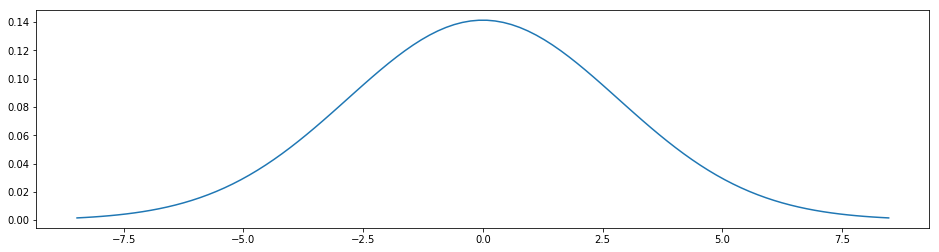

In [50]:
import matplotlib.mlab as mlab
mu = dd.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dd.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(x,mlab.normpdf(x, mu, sigma))

In [51]:
dd[dd > 2*dd.std()]

368        6.0
376       17.0
1024      13.0
1204       8.0
1205       8.0
1206       7.0
1655       6.0
3233      10.0
3955       8.0
11053     12.0
11475      9.0
11638      6.0
14939     15.0
15610      7.0
15886     12.0
17049     19.0
17511     11.0
20438     13.0
20663      9.0
21115      8.0
24133     18.0
24973      7.0
28569     15.0
31469     17.0
32031     13.0
32219      6.0
32563      6.0
35149      6.0
35937     13.0
39189      7.0
         ...  
43158     10.0
44270      7.0
46064      8.0
47622      6.0
47623     15.0
48157      7.0
48980      7.0
52062      6.0
52104      8.0
53761     14.0
53778      9.0
54381      6.0
57207      6.0
57448      6.0
57450     16.0
57821     15.0
59527      7.0
60885     12.0
61276      6.0
61277     14.0
61295      6.0
61531      9.0
62313      7.0
65231     14.0
65689      7.0
66057      7.0
66060     24.0
66061      6.0
66073     12.0
66074    121.0
Name: fuelVoltage, Length: 61, dtype: float64

In [52]:
a = dd.value_counts()
dd[dd != 0].median()

1.0

In [53]:
dd.mean(), dd.median(), dd.std()

(-0.001331819901626939, 0.0, 2.8242875593563723)

In [54]:
## Finding avgMax decay rate
avgDT, indexlst, max_dCRate = findMax_decayRate(df_clean2)

0.0
131.57
131.57
131.57
131.57
131.729
132.466
132.466
132.466
157.43200000000002
163.35
173.946
174.32500000000002
174.32500000000002
174.32500000000002
255.829
255.834
255.834
255.871
256.43
257.778
259.689
374.765
375.753
386.257
386.668
389.24
401.176
404.606
405.469
408.25
410.563
412.35
412.90000000000003
417.248
418.426
419.933
425.254
428.065
432.216
439.639
442.43600000000004
443.03700000000003
444.962
447.17400000000004
450.812
453.742
455.884
456.567
456.886
457.319
457.319
457.842
459.35200000000003
459.461
459.61400000000003
459.757
494.57
503.8
504.535
506.048
507.349
507.492
536.595
537.1560000000001
538.073
542.646
544.215
547.449
548.26
556.4590000000001
556.4590000000001
556.4590000000001
556.4590000000001
556.4590000000001
591.373
592.837
594.316
596.795
598.491
599.463
600.825
600.897
600.927
603.973
607.09
608.711
609.705
613.891
614.587
615.328
617.537
623.1370000000001
632.328
633.202
635.106
635.538
642.61
656.337
671.16
672.53
673.948
676.053
676.442
677.552
6

3352.32
3371.627
3373.994
3377.465
3380.3450000000003
3381.909
3382.9500000000003
3385.251
3389.9120000000003
3392.041
3392.516
3393.639
3396.483
3411.536
3415.638
3443.471
3444.714
3444.987
3447.442
3451.561
3454.605
3456.65
3458.074
3459.236
3459.236
3459.236
3459.294
3459.882
3459.886
3459.928
3460.302
3462.233
3463.02
3482.821
3487.184
3489.652
3497.206
3501.723
3505.966
3508.898
3510.299
3511.161
3511.161
3511.1710000000003
3511.174
3511.387
3517.5750000000003
3526.337
3526.495
3529.493
3529.761
3529.876
3529.968
3530.076
3531.116
3536.047
3539.763
3544.132
3548.458
3554.3070000000002
3557.337
3566.487
3568.996
3575.953
3579.748
3581.935
3582.6510000000003
3583.324
3584.304
3585.1800000000003
3587.146
3589.2000000000003
3589.774
3590.698
3593.502
3596.369
3597.281
3597.92
3600.617
3602.426
3605.381
3606.5190000000002
3606.731
3606.952
3608.4590000000003
3610.454
3630.042
3630.957
3633.583
3634.025
3634.5260000000003
3635.0950000000003
3635.0950000000003
3635.992
3640.237
3646.455


In [55]:
max_dCRate, avgDT.median(), round(avgDT.mean(),5)

(2.4343832820837217, 0.0007656967840735069, 40.94014)

In [56]:

a = int(-3)
if a:
    print (a)

-3


In [57]:
def jump_point2(dff, level = 0.05, fuelMax=100, fuelMin=0):
    x = np.array(dff.index)
    y = np.array(dff.fuelVoltage)
    d = np.array(dff.distance)
    
    #######################################################################
    ## No. of Neighbourhood pts , dependent on sampling Rate of IoT device
    ## Criteria Set = Avg No. of points inside 10Km window will be considered
    n = int(10000/(dff.distance.max()/len(dff)))
    print (n)
    level = level*(fuelMax - fuelMin)
    theft_pts = []
    refpts = []
    rctr = 0
    ctr = 0
    i = 0
    
    for i in range(1, len(x)):
        try:
            #             d1 =abs(y[i+1] - y[i])
            #             d2 =abs(y[i+2] - y[i])
            d_forward = (y[i + 1:i + n] - y[i])
            d_backward = (y[i + 1] - y[i - n:i])
            disfor.append(d[i + n] - d[i])
            disback.append(d[i] - d[i-n])
            # print (d_backward)
            
        except:
            pass
            #print("**")
        # dd1.append(d1)
        # dd2.append(d2)
        # if (d1 >= 0.05) & (d2 >= 0.05)&(d3 >= 0.05)&(d4 >= 0.05)&(d5 >= 0.05)&(d5 >= 0.05):

        ###########################################################################
        #### Finding probable refueling Points
        if ((sum(d_forward > 1 * 3 * level) in list(range(n-1, n+1)))):  # & (sum(d_forward<0.1) == 19)):
            if (sum(d_backward > 1 * 3 * level) in list(range(n-1, n+1))):
                refpts.append(dff.index[i])
                rctr += 1

        ############################################################################
        #### Finding probable theft points
        if ((sum(d_forward < -1 * level) in list(range(n-1, n+1)))):  # & (sum(d_forward<0.1) == 19)):
            if (sum(d_backward < -1 * level) in list(range(n-1, n+1))):
                theft_pts.append(dff.index[i])
                ctr += 1
                # print(theft_pts, ctr)

        if (ctr >= 2):
            if ((theft_pts[ctr - 1] - theft_pts[ctr - 2]) in list(range(1, 6))):
                theft_pts.pop(ctr - 2)
                ctr -= 1
                # print (i)

                # dd1.append(0)
                # dd2.append(0)
    # dff['dd1'] = pd.Series(dd1)
    # dff['dd2'] = pd.Series(dd2)
    refpts = pd.Series(refpts)
    #shift = abs(refpts.shift(-1) - refpts)
    #print(shift)
    #print ((shift[shift <=5]), refpts[shift[shift <=5]]
    
    print(len(theft_pts))
    return theft_pts, refpts

In [58]:
theft_pts, refpts = jump_point2(df_clean2, 0.01, fuelMax, fuelMin)

40
84


In [59]:
def check_refpts_dropList(refpts):
    
    refpts = pd.Series(refpts)
    refdt = pd.DataFrame()
    refdt['refpts'] = refpts
    refdt['shift'] = refpts.shift(-1) - refpts
    refdt ['dist'] = pd.Series(df_clean2.distance[refpts].reset_index(drop= True))
    i = 0
    dropIndexList = []
    while i in range(len(refdt)):
        
        if refdt.loc[i,'shift'] <= 5:
            i+=1
            while (refdt.loc[i,'shift']  <=5) :
                dropIndexList.append(refdt.refpts[i])
                i+=1
        i+=1
    
    refdt['drop'] = refdt.refpts.apply(lambda x: 'Y' if (x in dropIndexList) else 'N')
    refdt = refdt[refdt['drop']=='N'].reset_index(drop=True)
    return refdt, dropIndexList    


ref , drop = check_refpts_dropList(refpts)


In [60]:
ref[ref['drop']=='Y'].reset_index(drop= True)


,refpts,shift,dist,drop


In [61]:
theft_pts, refpts = findtheft(df_clean2, fuelMax, fuelMin,0)

Points per 10Km:  32
84
Dataset_1 Theft & Refuel points Indentified


In [62]:
theft_pts2, refpts2 = findtheft(dfcln2, fuelMax, fuelMin,0)

Points per 10Km:  17
319
Dataset_1 Theft & Refuel points Indentified


In [63]:
dff2[dff2.datetime<=df_clean.datetime.min()]

,datetime,lat,long,speed,distance,fuelVoltage,dev_state
0,2017-11-30 17:42:33,21.6106283,82.0531617,0.0,0.0,296.0,1
1,2017-11-30 17:43:17,21.6106417,82.0531733,0.0,0.0,384.0,1


In [64]:
int(10000/(df_clean.distance.max()/len(df_clean2)))

40

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


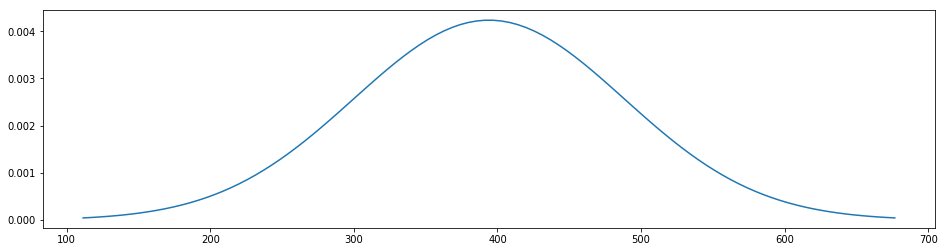

In [65]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(x,mlab.normpdf(x, mu, sigma))

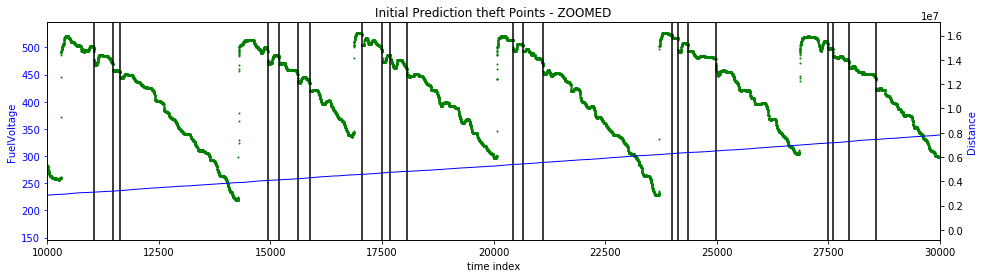

In [66]:
xlim = [10000,30000]
ylim = []
%matplotlib inline
plot_theftpts(df_clean2,refPts=[],theftpts=theft_pts,  xlim = xlim, ylim1= ylim)

In [67]:
len(refpts)

66

In [68]:
df_clean.distance.max() - df_clean.distance[0] 

16277888.0

In [69]:
import time
srt = time.time()
theft_df = dc.generate_TheftTable(df_clean2,theft_pts,max_dCRate, fuelMax, fuelMin)
print (time.time() - srt)

84
0.05789995193481445


In [70]:
def check_refpts_dropList(refdt):

    refdt['shift'] = abs(refdt['refuel_index'].shift(-1) - refdt['refuel_index'])
    #refdt['dist'] = pd.Series(df_clean2.distance[refpts].reset_index(drop=True))
    i = 0
    dropIndexList = []
    while i in range(len(refdt)):

        if refdt.loc[i, 'shift'] <= 5:
            i += 1
            while (refdt.loc[i, 'shift'] <= 5):
                dropIndexList.append(refdt.loc[i,'refuel_index'])
                i += 1
        i += 1

    refdt['drop'] = refdt.refuel_index.apply(lambda x: 'Y' if (x in dropIndexList) else 'N')
    print (len(refdt))
    refdt = refdt[refdt['drop'] == 'N'].reset_index(drop= True)
    return refdt, dropIndexList


def generate_ReFuelTable(df_cleaned, ref_pts, fuelMax, fuelMin):
    refuel_df = pd.DataFrame()
    refuel_df['refuel_index'] = [df_cleaned.index[i] for i in ref_pts]
    refuel_df['lat'] = [df_cleaned.lat[i] for i in ref_pts]
    refuel_df['long'] = [df_cleaned.long[i] for i in ref_pts]
    refuel_df['refuel_time'] = [df_cleaned.datetime[i] for i in ref_pts]

    refuel_df, dropIndex = check_refpts_dropList(refuel_df.copy())
    df_cleaned = df_cleaned.drop(dropIndex)


    for i,j in zip(refuel_df.refuel_index, refuel_df.index):
        success = 0
        pos = 1
        while(success ==0):
            try:
                refuel_df.loc[j,'fuel_VoltageJump'] = (df_cleaned.fuelVoltage[i+pos] - df_cleaned.fuelVoltage[i])
                refuel_df.loc[j,'fuel_VoltageJump(%)'] = 100 * (df_cleaned.fuelVoltage[i+pos] - df_cleaned.fuelVoltage[i]) / (fuelMax - fuelMin)
                refuel_df.loc[j,'dist_jump(KM)'] = (df_cleaned.distance[i + pos] - df_cleaned.distance[i]) * (.001)
                refuel_df.loc[j,'time_jump'] = (df_cleaned.datetime[i + pos] - df_cleaned.datetime[i])
                success =1
            except:
                pos +=1

    refuel_df['fuel_VoltageJump(%)'] = refuel_df['fuel_VoltageJump(%)'].apply(lambda x: round(x,2))

    # result_df.to_csv(r"G:\Analytics\FuelAnalysis\results\reults.csv")

    # plt.plot(result_df.theft_time, result_df.FuelPerKM)
    # plt.semilogy()
    # plt.show()
    print(refuel_df)
    return refuel_df

In [71]:

srt = time.time()
refuel_df = generate_ReFuelTable(df_clean2, refpts, fuelMax, fuelMin)
print (time.time() - srt)

66
    refuel_index                 lat               long         refuel_time   shift drop  fuel_VoltageJump  fuel_VoltageJump(%)  dist_jump(KM) time_jump
0            168  21.281616699999997         82.8367533 2017-12-02 06:56:01     3.0    N              39.0                10.71          0.422  00:00:30
1            175          21.2884983  82.86180829999999 2017-12-02 06:59:32  1081.0    N              22.0                 6.04          0.073  00:00:30
2           1256           21.277245           82.81446 2017-12-06 06:43:52  2252.0    N              22.0                 6.04          0.000  00:00:30
3           3508           21.280665         82.8322833 2017-12-09 15:04:42     1.0    N             194.0                53.30          0.081  00:05:17
4           3510          21.2804217         82.8315183 2017-12-09 15:09:59    15.0    N              23.0                 6.32          0.217  00:00:30
5           3525  21.277233300000002         82.8144233 2017-12-10 03:32:13    

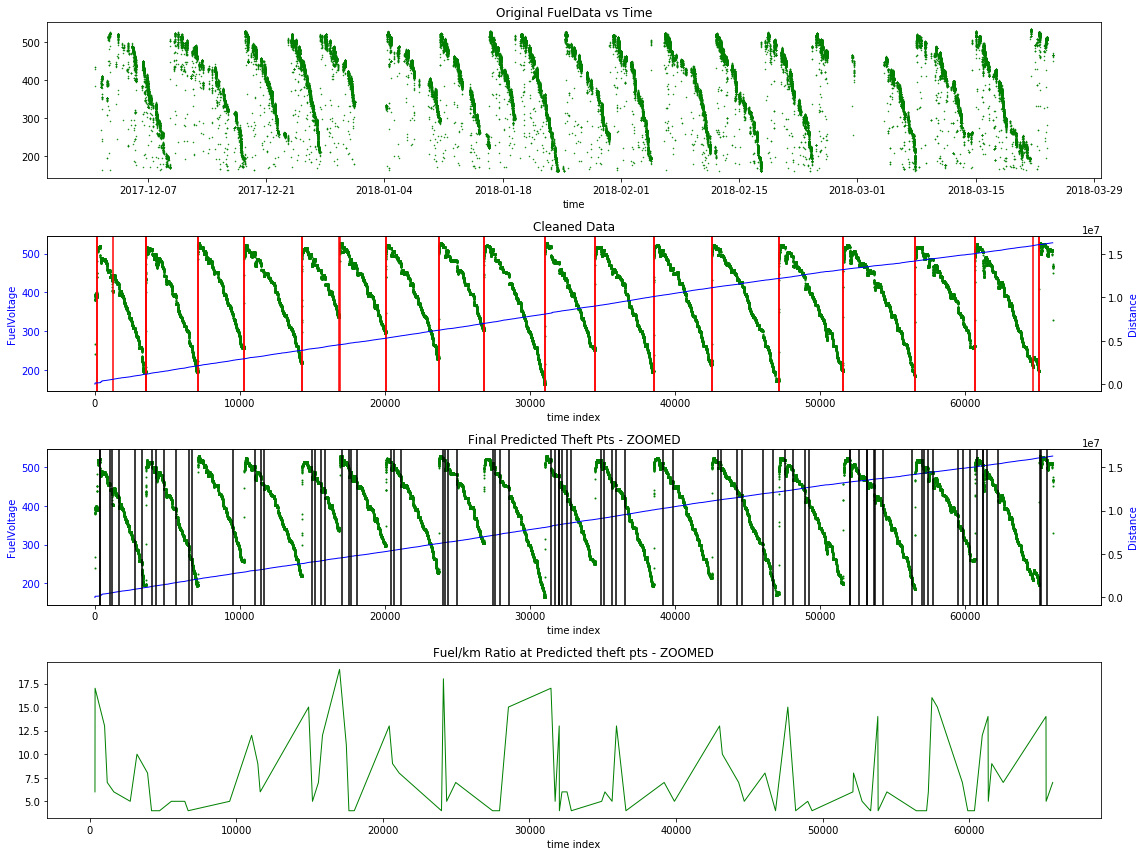

In [72]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)
%matplotlib inline
plot_Results(dff,df_clean2, theft_df, theft_pts, refuel_df['refuel_index'] , xlim = [], ylim1=ylim);
#ctr+=1
#print(refuel_df)

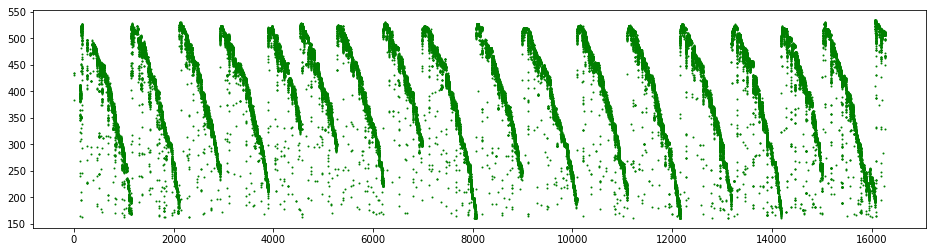

In [73]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df_clean.distance*0.001, df_clean.fuelVoltage, 'g.', markersize = 2)

In [74]:
def findAVG2(cleanDf, Dmax, fuelmax, fuelmin):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    dfW = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    dfmax = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/50
    
    avgdt_lst = []
    mean_lst = []
    median_lst = []
    indexlst_lst = []
    ctr = 0
    df1 = 0
    print(Dmax, dfW, dfmax)
    while dfW < dfmax:
        print (ctr)
        avgDT = []
        indexlst = []
        print ("***********************************",dfW)
        i=0
        print(0.01*(fuelmax- fuelmin))
        while i<len(cleanDf): 
            df = 0
            dfRef = cleanDf.fuelVoltage[i]
            dsRef = cleanDf.distance[i]
            pos = cleanDf.index[i]
            while (df<=dfW  and i<len(cleanDf)):
                df = dfRef - cleanDf.fuelVoltage[i] 
                if df <0 :
                    dfRef = cleanDf.fuelVoltage[i]
                    pos = cleanDf.index[i]
                    dsRef = cleanDf.distance[i]
                i+=1
                #print(i)
            
            if i<len(cleanDf):
                ds = cleanDf.distance[i] - dsRef
                if df>0 :
                    #print (i)
                    if ds==0:
                        ds = df/1000
                    avg = df/ds
                    if df > 0.01*(fuelmax- fuelmin):
                        if avg >= 5:
                            indexlst.append(pos)
                            print("df = ",df, "***df/ds = ",df/ds,"****",pos)
                    
                    avgDT.append(avg)
                    
            
        print(indexlst)
        indexlst = pd.Series(indexlst)
        shift = indexlst.shift(-1) - indexlst
        indexlst = indexlst[shift > 15]
        
        print(indexlst)
        
        
        
        #print(dfW)
        indexlst_lst.append(indexlst)
        if len(avgDT)!=0 :
            avgdt_lst.append(avgDT)
            med = pd.Series(avgDT).median()
            mean = pd.Series(avgDT).mean()
            #print (med,mean,mode)

            median_lst.append(med)
            mean_lst.append(mean)
        ctr+=1
        dfW += dfmax/10
        print (dfW)

        
    return [median_lst,mean_lst], avgdt_lst, indexlst_lst

central_DT2, avgLst2, indexlst2 = findAVG2(df_clean2, Dmax, fuelMax, fuelMin)

16277888.0 0.728 7.28
0
*********************************** 0.728
3.64
df =  8.0 ***df/ds =  1000.0 **** 1200
df =  7.0 ***df/ds =  1000.0 **** 1206
df =  12.0 ***df/ds =  1000.0 **** 11053
df =  5.0 ***df/ds =  1000.0 **** 24354
df =  5.0 ***df/ds =  1000.0 **** 27599
df =  4.0 ***df/ds =  1000.0 **** 27602
df =  6.0 ***df/ds =  1000.0 **** 32562
df =  7.0 ***df/ds =  1000.0 **** 39189
df =  8.0 ***df/ds =  1000.0 **** 52104
df =  16.0 ***df/ds =  1000.0 **** 57449
df =  14.0 ***df/ds =  7.0 **** 61277
df =  5.0 ***df/ds =  1000.0 **** 65239
[1200, 1206, 11053, 24354, 27599, 27602, 32562, 39189, 52104, 57449, 61277, 65239]
1      1206
2     11053
3     24354
5     27602
6     32562
7     39189
8     52104
9     57449
10    61277
dtype: int64
1.456
1
*********************************** 1.456
3.64
df =  7.0 ***df/ds =  1000.0 **** 1206
df =  4.0 ***df/ds =  1000.0 **** 4770
df =  12.0 ***df/ds =  1000.0 **** 11053
df =  5.0 ***df/ds =  1000.0 **** 27599
df =  4.0 ***df/ds =  1000.0 ****

df =  17.0 ***df/ds =  999.9999999999999 **** 66062
[39, 378, 1206, 4885, 21943, 24353, 27602, 32563, 39189, 46952, 53777, 57449, 61527, 66062]
0        39
1       378
2      1206
3      4885
4     21943
5     24353
6     27602
7     32563
8     39189
9     46952
10    53777
11    57449
12    61527
dtype: int64
6.551999999999999
8
*********************************** 6.551999999999999
3.64
df =  8.0 ***df/ds =  1000.0 **** 1200
df =  7.0 ***df/ds =  1000.0 **** 1206
df =  7.0 ***df/ds =  7.0 **** 4882
df =  14.0 ***df/ds =  1000.0 **** 11052
df =  7.0 ***df/ds =  1000.0 **** 27602
df =  7.0 ***df/ds =  1000.0 **** 39189
df =  10.0 ***df/ds =  1000.0 **** 43158
df =  7.0 ***df/ds =  1000.0 **** 46952
df =  10.0 ***df/ds =  1000.0 **** 53777
df =  16.0 ***df/ds =  1000.0 **** 57450
df =  14.0 ***df/ds =  7.0 **** 61277
df =  10.0 ***df/ds =  1000.0 **** 61529
df =  8.0 ***df/ds =  1000.0 **** 65688
df =  17.0 ***df/ds =  999.9999999999999 **** 66062
[1200, 1206, 4882, 11052, 27602, 39189,

In [75]:
a = pd.Series([1,2,3,4,5,6])
b = pd.Series([0,0,1,1,0,1])
a[b==0]

0    1
1    2
4    5
dtype: int64

In [78]:
pd.Series(a>2).mean()

0.6666666666666666

In [76]:
def findMax_decayRate(cleanDf):

    i = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    avgDT = []
    indexlst = []
    
    while i<len(cleanDf): 
        df = 0
        dfRef = cleanDf.fuelVoltage[i]
        dsRef = cleanDf.distance[i]
        pos = i
        while (df<=dt  and i<len(cleanDf)):
            df = dfRef - cleanDf.fuelVoltage[i] 
            if df <0 :
                dfRef = cleanDf.fuelVoltage[i]
                pos = i
            i+=1
            #print(i)

        if i<len(cleanDf):
            ds = cleanDf.distance[i] - dsRef
            if df>0 :
                #print (i)
                if ds==0:
                    ds = df/1000
                    #print("df = ",df,"****",i)
                avg = df/ds
                avgDT.append(avg)
                indexlst.append(cleanDf.index[i])

        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        avg = pd.Series(avgDT)
        max_dCRate = avg.median()+ 3*abs(avg - avg.median()).median()
        
    return pd.Series(avgDT), max_dCRate

avgDT,max_dCRate = findMax_decayRate(df_clean2)

In [77]:
len(df_clean2), len(avgDT), len(indexlst2), max_dCRate

(66076, 4601, 10, 0.002463800757675585)

In [78]:
sum(avgDT==1000)

192

Text(0.5,1,'Median dF/dS vs Increasing Ds')

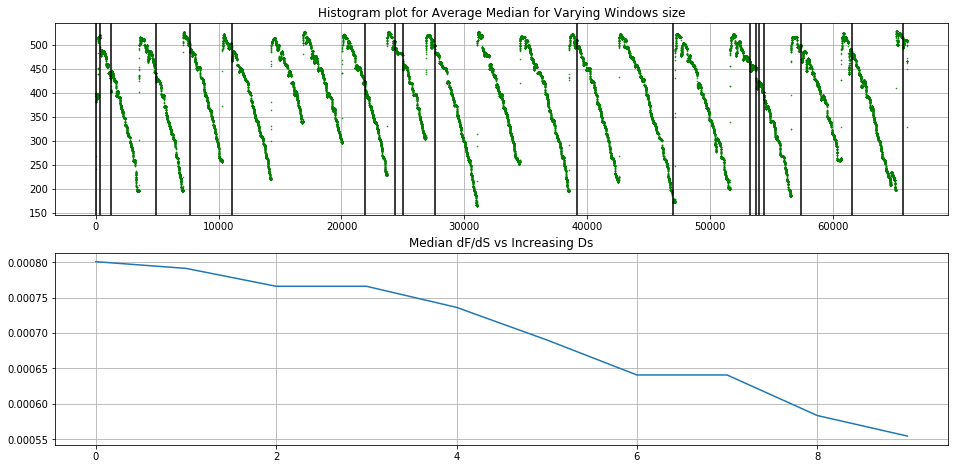

In [90]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(df_clean2.index, df_clean2.fuelVoltage, 'g.', markersize=1)
for pt in indexlst2[5]:
    plt.axvline(pt, color = 'black');
    #plt.text(pt, 200, "sds")
plt.grid()
plt.title('Histogram plot for Average Median for Varying Windows size')
#plt.xlim(0,30000)
#plt.text(1220, 200, "sds")

plt.subplot(3,1,2)
plt.plot(central_DT2[0]);
#plt.ylim(0,.002)
plt.grid()
plt.title("Median dF/dS vs Increasing Ds")

interactive(children=(IntSlider(value=1, description='x', max=9), Output()), _dom_classes=('widget-interact',)…

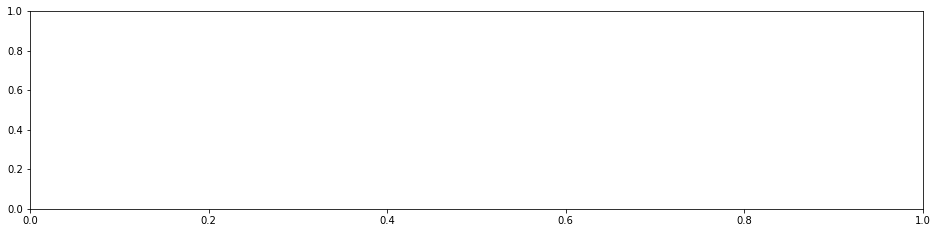

In [80]:
def f2(x):
    return x
def f(x):    
    index = indexlst2[x]
    avg = pd.Series(avgLst2[x])
    avg = pd.Series(avg)
    plt.rcParams['figure.figsize'] = [16,8]
    interact(f2, x=str(len(avg[avg>=100])));
    interact(f2, x=str(pd.Series(avg).median()+ 3*abs(avg - avg.median()).median()));
    plt.subplot(2,1,1)
    plt.plot(index, avg, 'g.')
    plt.semilogy()
    plt.axhline(pd.Series(avg).median(), color = 'red')
    plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    plt.axhline(pd.Series(avg).median()+ 4*abs(avg - avg.median()).median(), color = 'Blue')
    plt.axhline(pd.Series(avg).median()- 2*abs(avg - avg.median()).median(), color = 'Blue')
    abs(avg - avg.median()).median()
   # plt.ylim(0,0.05)
    plt.subplot(2,1,2)
    plt.plot(index,avg)
    plt.semilogy()
    plt.semilogx()
    #plt.ylim(0,0.1)
    #plt.axhline(pd.Series(avg).median(), color = 'red')
   # plt.axhline(pd.Series(avg).mean(), color = 'blue')
   ## plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    
    
interact(f, x= IntSlider(min=0, max=9, step=1,value=1));


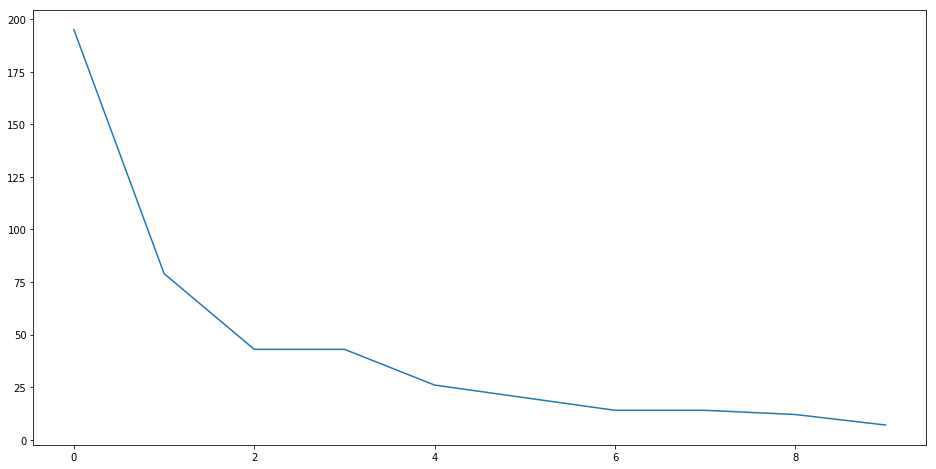

In [81]:
teftpt = []
for avg in avgLst2:
    avg = pd.Series(avg)
    teftpt.append(len(avg[avg>=100]))
plt.plot(teftpt)

In [82]:
IntProgress(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

IntProgress(value=7, description='Loading:', max=10)

In [83]:
 avg = pd.Series(avgLst2[0])
abs(avg - avg.median()).median()

0.00057925463682879

In [84]:
avg[avg!=1000].median(), avg[avg!=1000].std()

(0.0007374631268436578, 0.13737355549252178)

(0, 100)

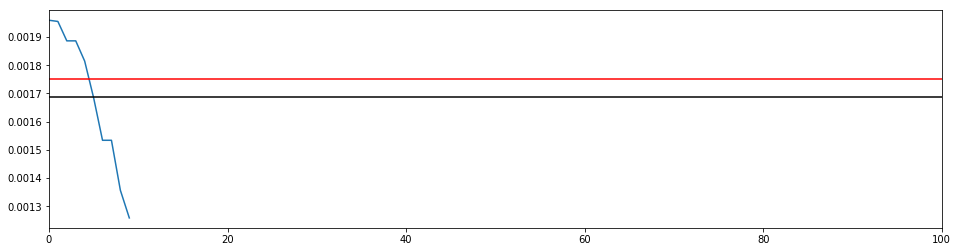

In [85]:
meddev = []
for  avg in avgLst2:
    avg = pd.Series(avg)
    meddev.append(pd.Series(avg).median()+ 2*abs(avg - avg.median()).median())
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(meddev)
plt.axhline(pd.Series(meddev).median(), color = 'red')
plt.axhline(pd.Series(meddev).mean(), color = 'Black')
plt.xlim(0,100)

In [86]:
pd.Series(meddev).mean(), max(meddev)

(0.0016869806725262413, 0.001959149786067508)

In [87]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

(0.0007680491551459293, 41.74181516209436, 0    1000.0
 dtype: float64)

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









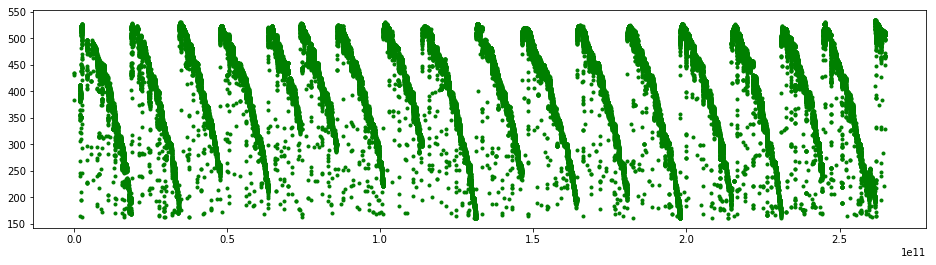

In [88]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')